In [1]:
%matplotlib notebook
from __future__ import division
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from schlichtanders.mymatplotlib import Centre
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import pandas as pd
import numpy as np
import theano
import theano.tensor as T
import theano_models as tm
import theano_models.deterministic_models as dm
import theano_models.probabilistic_models as pm

In [3]:
from experiment_toy_models import toy_likelihood

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [4]:
from schlichtanders.myfunctools import meanexp

In [5]:
toy1d = toy_likelihood(1)
toy2d = toy_likelihood(2)

toy1d_sampler = theano.function([], toy1d['outputs'])
toy2d_sampler = theano.function([], toy2d['outputs'])

toy1d_lik = theano.function(toy1d.logP['inputs'] + toy1d['inputs'], toy1d.logP['outputs'])
toy2d_lik = theano.function(toy2d.logP['inputs'] + toy2d['inputs'], toy2d.logP['outputs'])

In [6]:
toy1d

Merge2 { 'inputs': [TensorConstant{(1,) of 0.0}], 'outputs': GaussianNoise.outputs}

In [7]:
def make_prior(targets):
    total_size = tm.total_size(targets['inputs'])
    return tm.fix_params(pm.DiagGauss(output_size=total_size))
prior1 = make_prior(toy1d)
prior2 = make_prior(toy2d)

prior1_sampler = prior1.function()
prior2_sampler = prior2.function()

prior1_logP = prior1.logP.function()
prior2_logP = prior2.logP.function()

Samples

In [8]:
n_samples = 1000
toy1d_samples = [toy1d_sampler() for _ in xrange(n_samples)]
toy2d_samples = [toy2d_sampler() for _ in xrange(n_samples)]

overall log likelihood of sample is simple sum

In [9]:
def sample_lik1(w):
    return sum(toy1d_lik(s, w) for s in toy1d_samples)

def sample_lik2(w):
    return sum(toy2d_lik(s, w) for s in toy2d_samples)

In [24]:
normalizing_samples = 10000

normalizing_constant1 = meanexp([sample_lik1(prior1_sampler()) for _ in xrange(normalizing_samples)])
normalizing_constant2 = meanexp([sample_lik2(prior2_sampler()) for _ in xrange(normalizing_samples)])

In [11]:
@np.vectorize
def posterior1(w):
    return sample_lik1([w]) + prior1_logP([w]) - normalizing_constant1
    
@np.vectorize
def posterior2(w1, w2):
    return sample_lik2([w1, w2]) + prior2_logP([w1, w2]) - normalizing_constant2

In [22]:
ws = np.linspace(-1.5, 1.5, 100)
num_posterior1 = posterior1(ws)

In [12]:
_ws = np.linspace(-1.5, 1.5, 50)
W1, W2 = np.meshgrid(_ws, _ws)
num_posterior2 = posterior2(W1, W2)

In [13]:
num_posterior2

array([[ -6.42427797e+04,  -5.70121224e+04,  -5.08382342e+04, ...,
         -7.77496076e+02,  -2.12247433e+02,   1.00510926e+00],
       [ -6.16464133e+04,  -5.45677716e+04,  -4.85315067e+04, ...,
         -5.15397532e+02,  -8.77720555e+01,  -2.65351908e+01],
       [ -5.91035997e+04,  -5.21769738e+04,  -4.62783320e+04, ...,
         -3.06851853e+02,  -1.68495429e+01,  -1.07628356e+02],
       ..., 
       [ -1.04205538e+02,  -1.82850868e+01,  -3.12685779e+02, ...,
         -4.63495115e+04,  -5.22525516e+04,  -5.91840359e+04],
       [ -2.48237821e+01,  -9.09190080e+01,  -5.22942867e+02, ...,
         -4.86043976e+04,  -5.46450609e+04,  -6.17285609e+04],
       [  1.00510926e+00,  -2.17105794e+02,  -7.86752819e+02, ...,
         -5.09128365e+04,  -5.70911230e+04,  -6.43266387e+04]])

<IPython.core.display.Javascript object>


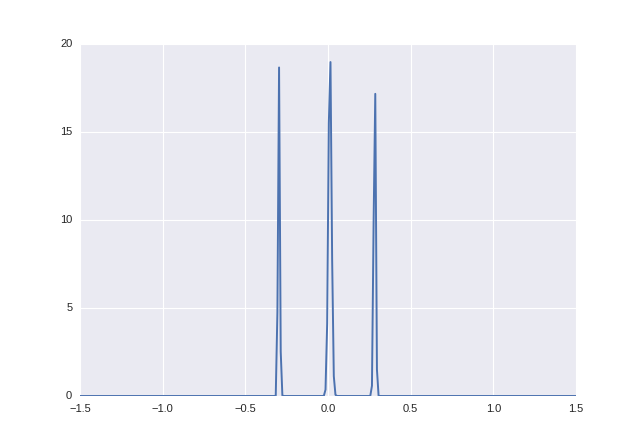

In [14]:
plt.figure()
plt.plot(ws, np.exp(num_posterior1))

<IPython.core.display.Javascript object>


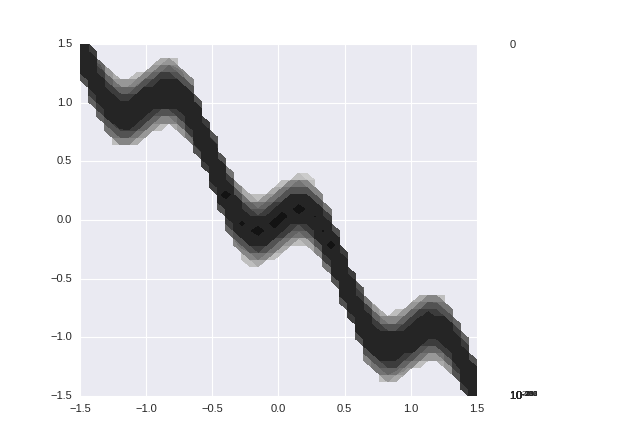

In [20]:
plt.figure()
plt.contourf(W1, W2, np.exp(num_posterior2), norm=LogNorm())
# plt.colorbar()

<IPython.core.display.Javascript object>


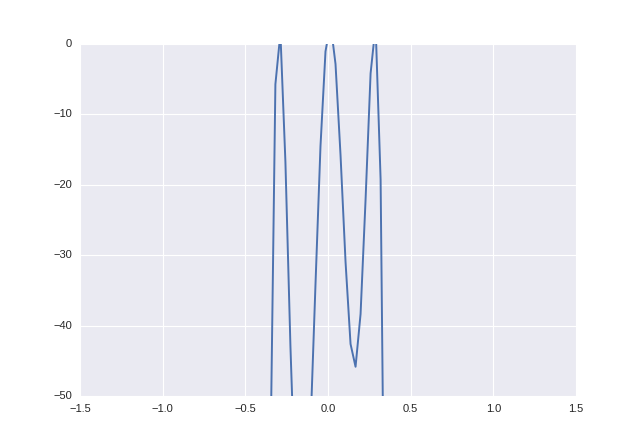

(-50, 0)

In [23]:
plt.figure()
plt.plot(ws, num_posterior1)
plt.ylim([-50, 0])

<IPython.core.display.Javascript object>


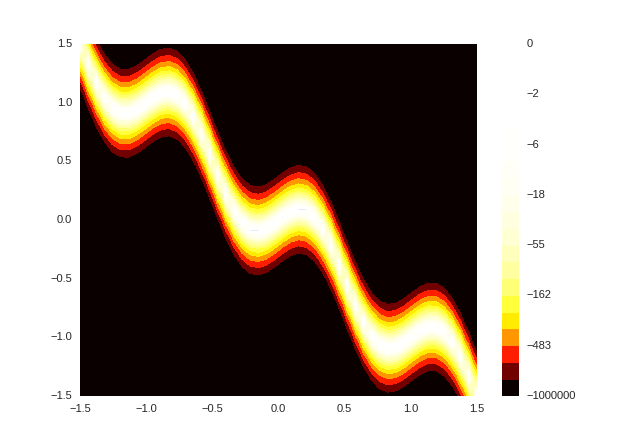

In [18]:
plt.figure()
levels = - np.r_[0, np.logspace(0, 3, 20)][::-1]
vmin=levels.min()
vmax=levels.max()
levels = np.r_[-10**6, levels]
plt.contourf(W1, W2, num_posterior2, levels, vmin=vmin, vmax=vmax, cmap=plt.cm.hot)
plt.colorbar()